In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold,train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('modified_df.csv')
df

,rs6971508_A,rs9260989_A,rs4267675_C,rs9261108_A,rs13121520_A,rs680331_G,rs9259910_A,rs2819493_A,rs4669685_A,rs6739054_G,...,rs17163535_G,rs7245800_G,rs1452671_A,rs5996200_A,rs10064142_G,rs2480693_A,rs2498947_A,rs12041577_A,rs324553_A,rs6834993_G
0,0,0,1,0,1,0,0,1,1,1,...,0,2,0,1,2,1,1,0,2,0
1,0,0,1,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,1,1
2,1,1,0,1,0,0,1,1,0,0,...,0,1,0,1,2,0,2,0,1,1
3,0,0,0,0,0,1,0,1,0,0,...,0,1,2,0,1,0,1,0,1,2
4,1,0,0,0,0,1,0,1,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5556,1,0,1,0,0,1,0,1,0,1,...,0,0,0,0,1,0,0,0,1,1
5557,0,0,0,0,0,1,0,2,1,1,...,0,0,0,0,0,1,0,0,1,1
5558,1,0,0,0,0,0,0,1,2,2,...,0,0,2,2,1,1,0,0,0,0
5559,0,0,0,0,0,0,0,0,0,0,...,0,0,2,0,0,1,0,1,0,0


In [3]:
target = np.array(np.load('target', allow_pickle=True)) - 1


In [6]:
def run_cross_validation(X_train, y_train, clf, resampler):
    # Initialize StratifiedKFold
    kfold = StratifiedKFold(n_splits=5)

    # Initialize lists to store metrics for each fold
    accuracy_scores, precision_scores, recall_scores, f1_scores, roc_auc_scores = [], [], [], [], []

    # Initialize a list to store the trained classifiers
    classifiers = []

    # Perform cross-validation manually
    for train_index, val_index in kfold.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Apply resampling if a resampler is provided
        if resampler is not None:
            X_resampled, y_resampled = resampler.fit_resample(X_train_fold, y_train_fold)
        else:
            X_resampled, y_resampled = X_train_fold, y_train_fold
        
        # Train the model without class_weight='balanced' and increased max_iter
        clf.fit(X_resampled, y_resampled)

        # Make predictions
        y_val_pred = clf.predict(X_val_fold)

        # Compute metrics and store them in lists
        accuracy_scores.append(accuracy_score(y_val_fold, y_val_pred))
        precision_scores.append(precision_score(y_val_fold, y_val_pred))
        recall_scores.append(recall_score(y_val_fold, y_val_pred))
        f1_scores.append(f1_score(y_val_fold, y_val_pred))
        roc_auc_scores.append(roc_auc_score(y_val_fold, clf.predict_proba(X_val_fold)[:, 1]))

        # Store the trained classifier
        classifiers.append(clf)
        print(f'roc_auc_scores{roc_auc_scores[-1]}')
    
    # Return average metrics and classifiers
    return (
        np.mean(accuracy_scores),
        np.mean(precision_scores),
        np.mean(recall_scores),
        np.mean(f1_scores),
        np.mean(roc_auc_scores),
        classifiers
    )


In [8]:
# Load the data
X = df.values
y = target

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)

clf = LogisticRegression(max_iter=1000)

# Initialize resampling methods
resampling_methods = [None, RandomOverSampler(random_state=42)]
resampling_names = ["No Resampling", "Random Over Sampling"]

# Initialize dictionary to store results
results1 = {}

# Loop over resampling methods
for resampler, name in zip(resampling_methods, resampling_names):
    print(f"Running cross-validation for: {name}")
    results1[name] = run_cross_validation(X, y, clf, resampler)
    
# Display results
for name, metrics in results1.items():
    print(f"\n==== {name} ====")
    print(f"Average Accuracy: {metrics[0]}")
    print(f"Average Precision: {metrics[1]}")
    print(f"Average Recall: {metrics[2]}")
    print(f"Average F1 Score: {metrics[3]}")
    print(f"Average ROC AUC: {metrics[4]}")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Running cross-validation for: No Resampling
roc_auc_scores0.9999686986462164
roc_auc_scores0.999897482000205
roc_auc_scores0.9999608334638885
roc_auc_scores0.907222309258969
roc_auc_scores0.9750117499608334
Running cross-validation for: Random Over Sampling
roc_auc_scores0.9999686986462164
roc_auc_scores0.9998817100002366
roc_auc_scores0.9999608334638885
roc_auc_scores0.9112642957856806
roc_auc_scores0.9762337458875137

==== No Resampling ====
Average Accuracy: 0.954320425061568
Average Precision: 0.9540635353616465
Average Recall: 0.9979633401221996
Average F1 Score: 0.9751645746829908
Average ROC AUC: 0.9764122146660226

==== Random Over Sampling ====
Average Accuracy: 0.9620529452448823
Average Precision: 0.9652001457746406
Average Recall: 0.9936863543788187
Average F1 Score: 0.9790839264467419
Average ROC AUC: 0.977461856756707


In [119]:
# Load the data
X = df.values
y = target

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=True)

X = encoder.fit_transform(X)

resampler=RandomOverSampler(random_state=42)

X_resampled, y_resampled = resampler.fit_resample(X, y)

lrclf = LogisticRegression(max_iter=1000)

lrclf.fit(X_resampled, y_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


LogisticRegression(max_iter=1000)

In [120]:
# Get the feature names from the DataFrame
feature_names = df.columns

# Get the coefficients from the logistic regression model
coefficients = lrclf.coef_[0]

# Create a dictionary to store feature importance
feature_importance = {}

# Pair each feature name with its corresponding coefficient
for feature, coefficient in zip(feature_names, coefficients):
    feature_importance[feature] = abs(coefficient)

# Sort the feature importance dictionary by values in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get the top 100 features with higher importance
top_features = sorted_importance

In [121]:
# Read the selected_snps_df.csv file
selected_snps_df = pd.read_csv("selected_snps_df.csv")

# Create a DataFrame from the top_features list
top_features_df = pd.DataFrame(sorted_importance, columns=["Feature", "Importance"])

top_features_df

,Feature,Importance
0,rs16914113_G,4.153594e-02
1,rs6901944_G,3.654352e-02
2,rs1152655_A,3.510495e-02
3,rs2506947_G,3.459225e-02
4,rs1462339_G,3.429564e-02
...,...,...
29995,rs721367_A,1.022738e-06
29996,rs36073277_G,9.838533e-07
29997,rs557989_C,7.487790e-07
29998,rs12541094_A,6.547945e-07


In [122]:
top_features_df.to_csv('LR_OH_WEIGHT.csv', index=False)

In [50]:
# Create a new column for p-values in the top_features_df
top_features_df["p-value"] = None

# Iterate over the rows in top_features_df
for i, row in top_features_df.iterrows():
    feature = row["Feature"]
    # Check if the feature is present in the selected_snps_df
    if feature in selected_snps_df["SNP"].values:
        # Find the corresponding row in selected_snps_df
        matched_row = selected_snps_df[selected_snps_df["SNP"] == feature]
        # Get the p-value from the matched row and assign it to the "p-value" column in top_features_df
        top_features_df.at[i, "p-value"] = matched_row["p-value"].values[0]

# Filter the top 100 features from selected_snps_df
top_100_selected = selected_snps_df.head(100)
# Convert p-values to -log10(p value)
top_features_df["-log10(p value)"] = -np.log10(top_features_df["p-value"].astype(float))
top_features_df

,Feature,Importance,p-value,-log10(p value)
0,rs16914113_G,4.153594e-02,0.0,7.204349
1,rs6901944_G,3.654352e-02,0.006613,2.179589
2,rs1152655_A,3.510495e-02,0.006613,2.179610
3,rs2506947_G,3.459225e-02,0.005752,2.240150
4,rs1462339_G,3.429564e-02,0.000054,4.263946
...,...,...,...,...
29995,rs721367_A,1.022738e-06,0.004988,2.302098
29996,rs36073277_G,9.838533e-07,0.00241,2.617907
29997,rs557989_C,7.487790e-07,0.000185,3.732798
29998,rs12541094_A,6.547945e-07,0.006128,2.212679


In [51]:
top_features_df = top_features_df.head(100)

In [52]:
top_features_df.to_csv('LR_OH_WEIGHT.csv', index=False)

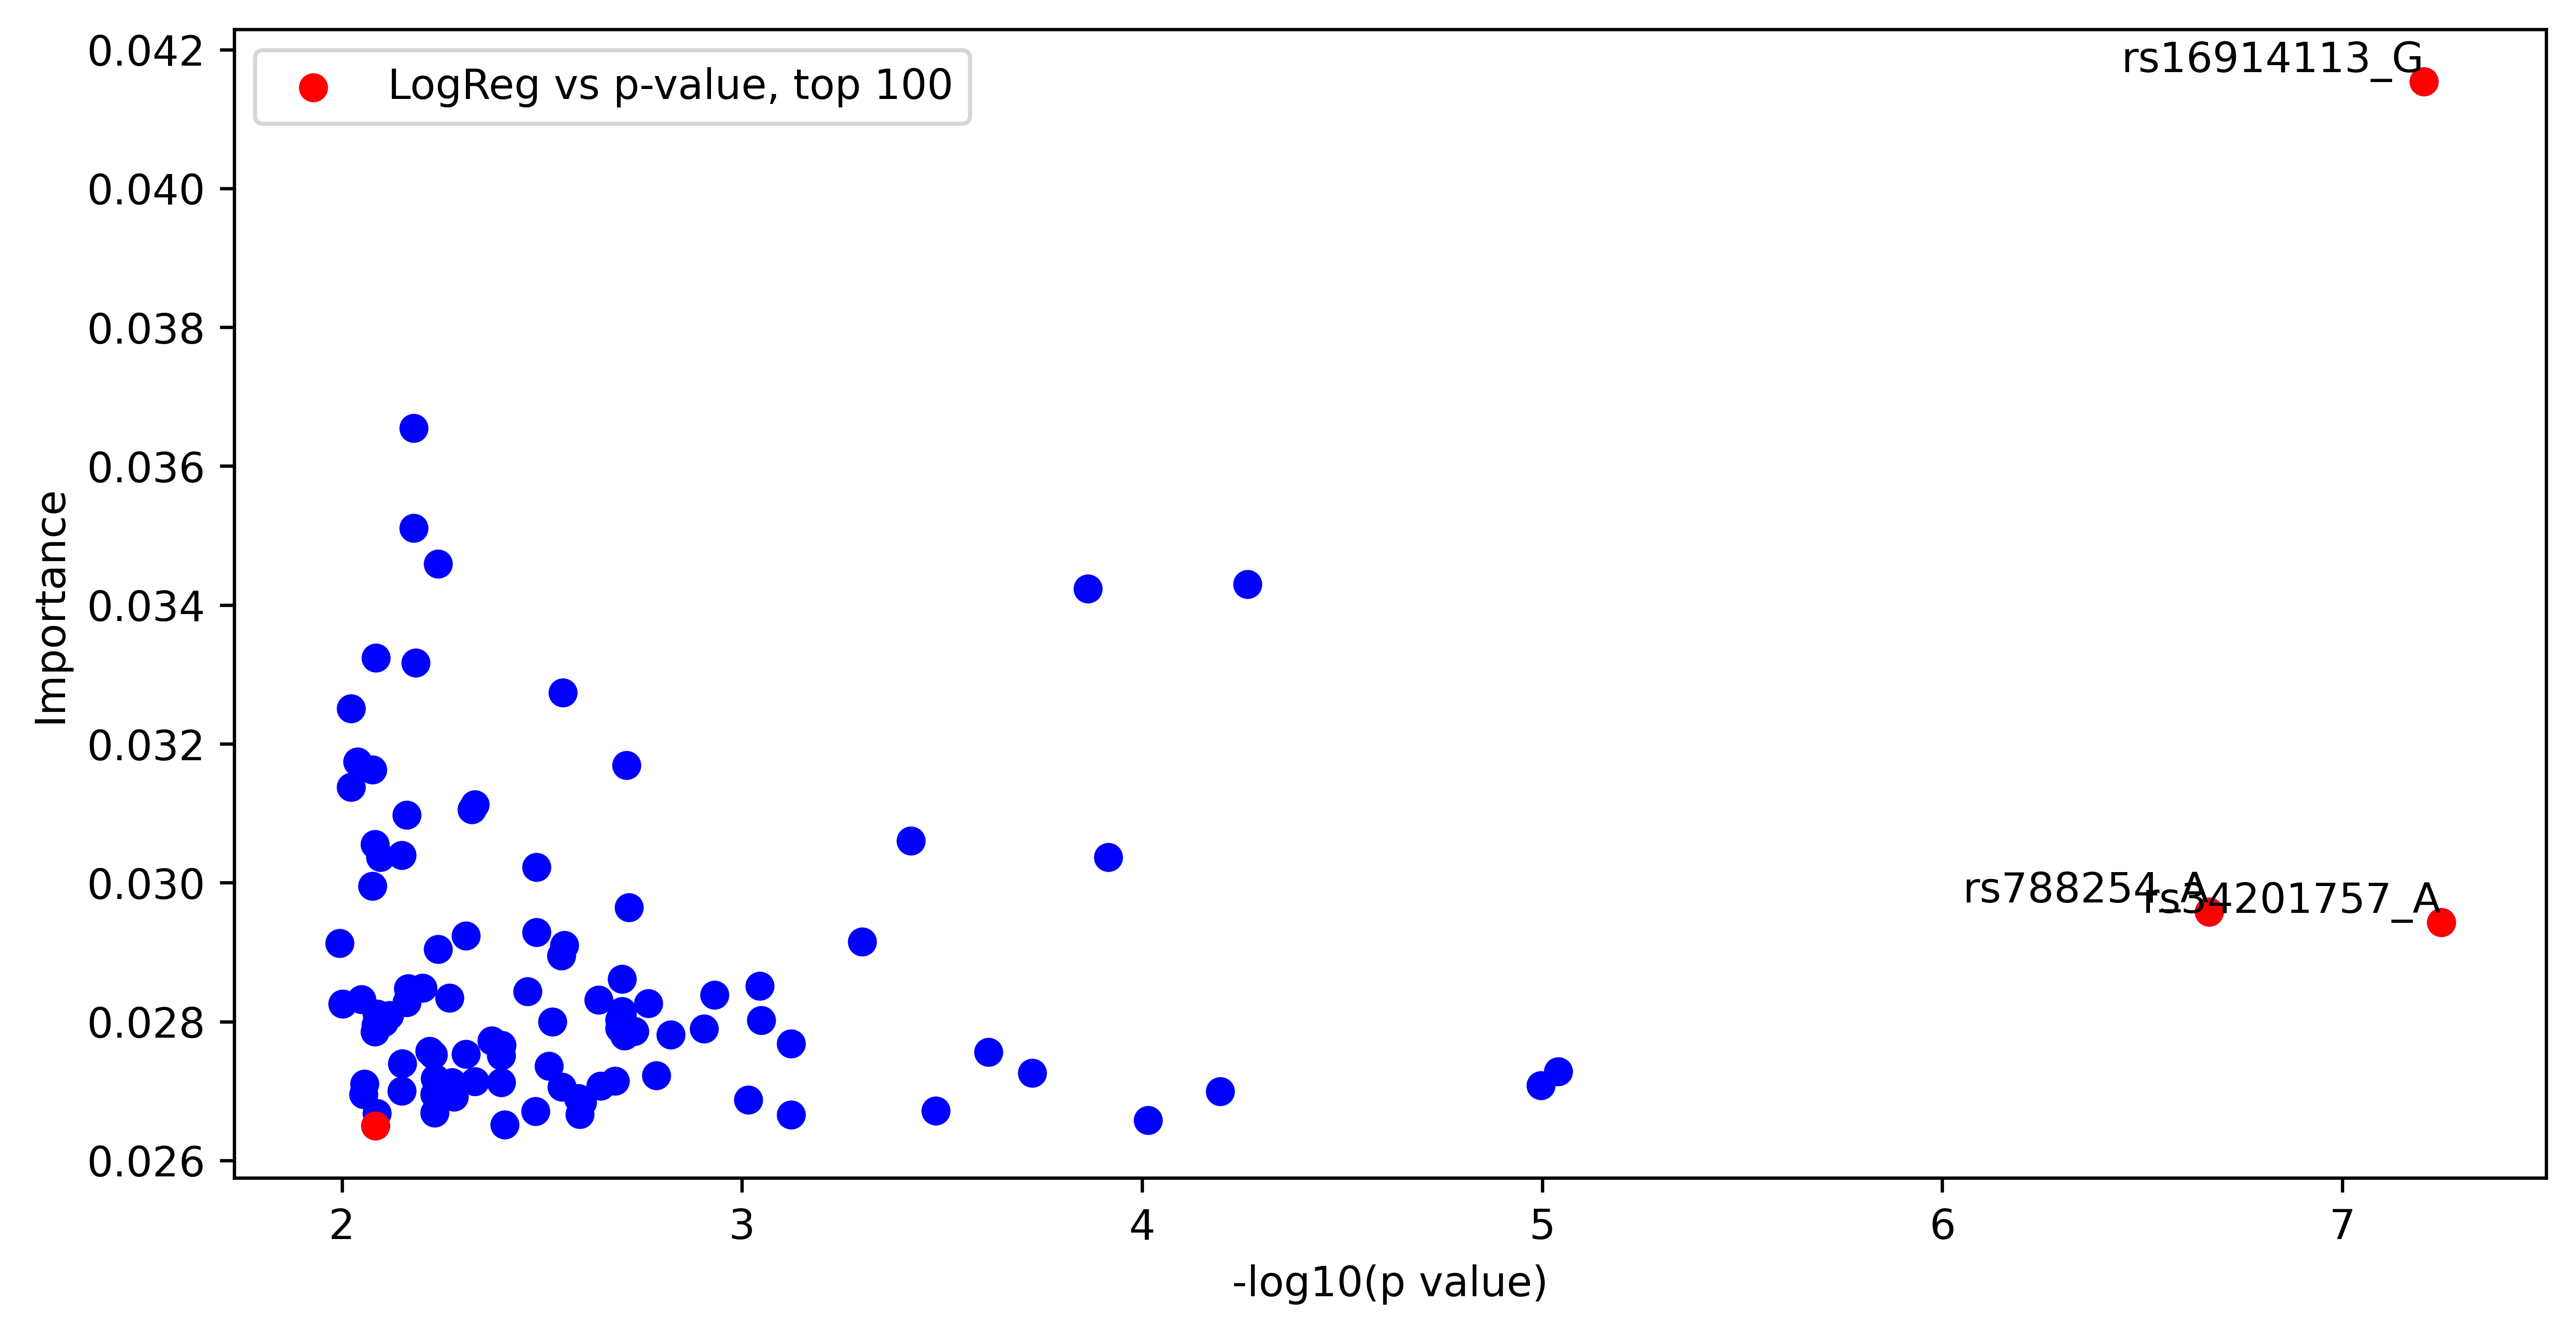

In [53]:
import matplotlib.pyplot as plt
# Plot the figure
plt.figure(figsize=(10, 5), dpi=600)
plt.scatter(top_features_df["-log10(p value)"], top_features_df["Importance"], color="blue")
# Highlight features in top_100_selected as red
for index, row in top_features_df.iterrows():
    feature = row["Feature"]
    if feature in top_100_selected["SNP"].values:
        plt.scatter(row["-log10(p value)"], row["Importance"], color="red")
        plt.annotate(feature, xy=(row["-log10(p value)"], row["Importance"]) ,ha='right', va='bottom')
        
plt.scatter(row["-log10(p value)"], row["Importance"], color="red", label='LogReg vs p-value, top 100')

plt.xlabel("-log10(p value)")
plt.ylabel("Importance")
plt.legend()
plt.show()


In [60]:
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,confusion_matrix,roc_curve
import xgboost as xgb
import time
import warnings



In [61]:
# Instantiate an XGBoost classifier
model = xgb.XGBClassifier( seed=0,
                          objective='binary:logistic',
                          booster='gbtree',
                          learning_rate = 0.06,
                          n_estimators=1000,
                          max_depth = 4,
                          min_child_weight = 20,
                          gamma = 0.6,
                          subsample=0.2,
                          colsample_bytree=0.05,
                          tree_method='gpu_hist'
                          )

In [29]:
# Load the data
X = df.values
y = target

# Apply one-hot encoding
#encoder = OneHotEncoder(sparse=True)
#X = encoder.fit_transform(X)

# Initialize resampling methods
resampling_methods = [None, RandomOverSampler(random_state=42)]
resampling_names = ["No Resampling", "Random Over Sampling"]

# Initialize dictionary to store results
results_XGB = {}

# Loop over resampling methods
for resampler, name in zip(resampling_methods, resampling_names):
    print(f"Running cross-validation for: {name}")
    results_XGB[name] = run_cross_validation(X, y, model, resampler)
    
# Display results
for name, metrics in results1.items():
    print(f"\n==== {name} ====")
    print(f"Average Accuracy: {metrics[0]}")
    print(f"Average Precision: {metrics[1]}")
    print(f"Average Recall: {metrics[2]}")
    print(f"Average F1 Score: {metrics[3]}")
    print(f"Average ROC AUC: {metrics[4]}")

Running cross-validation for: No Resampling
roc_auc_scores0.9844275764926832
roc_auc_scores0.9786525980426949
roc_auc_scores0.9780745730847564
roc_auc_scores0.41476578411405296
roc_auc_scores0.6879132069559768
Running cross-validation for: Random Over Sampling
roc_auc_scores0.990507864465138
roc_auc_scores0.9782977280434045
roc_auc_scores0.9874980416731943
roc_auc_scores0.4104339652201159
roc_auc_scores0.7122904590318033

==== No Resampling ====
Average Accuracy: 0.954320425061568
Average Precision: 0.9540635353616465
Average Recall: 0.9979633401221996
Average F1 Score: 0.9751645746829908
Average ROC AUC: 0.9764122146660226

==== Random Over Sampling ====
Average Accuracy: 0.9620529452448823
Average Precision: 0.9652001457746406
Average Recall: 0.9936863543788187
Average F1 Score: 0.9790839264467419
Average ROC AUC: 0.977461856756707


In [30]:
# Load the data
X = df.values
y = target

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=True)
X = encoder.fit_transform(X)

# Initialize resampling methods
resampling_methods = [None, RandomOverSampler(random_state=42)]
resampling_names = ["No Resampling", "Random Over Sampling"]

# Initialize dictionary to store results
results = {}

# Loop over resampling methods
for resampler, name in zip(resampling_methods, resampling_names):
    print(f"Running cross-validation for: {name}")
    results[name] = run_cross_validation(X, y, model, resampler)
    
# Display results
for name, metrics in results1.items():
    print(f"\n==== {name} ====")
    print(f"Average Accuracy: {metrics[0]}")
    print(f"Average Precision: {metrics[1]}")
    print(f"Average Recall: {metrics[2]}")
    print(f"Average F1 Score: {metrics[3]}")
    print(f"Average ROC AUC: {metrics[4]}")

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Running cross-validation for: No Resampling
roc_auc_scores0.9869864621644887
roc_auc_scores0.9757032340485936
roc_auc_scores0.9778395738680871
roc_auc_scores0.4914460285132384
roc_auc_scores0.7167123609587969
Running cross-validation for: Random Over Sampling
roc_auc_scores0.9910791141716879
roc_auc_scores0.9718548660562903
roc_auc_scores0.9827432241892526
roc_auc_scores0.42444775184082717
roc_auc_scores0.7206015979946734

==== No Resampling ====
Average Accuracy: 0.954320425061568
Average Precision: 0.9540635353616465
Average Recall: 0.9979633401221996
Average F1 Score: 0.9751645746829908
Average ROC AUC: 0.9764122146660226

==== Random Over Sampling ====
Average Accuracy: 0.9620529452448823
Average Precision: 0.9652001457746406
Average Recall: 0.9936863543788187
Average F1 Score: 0.9790839264467419
Average ROC AUC: 0.977461856756707


In [62]:
# Load the data
X = df.values
y = target

# Apply one-hot encoding
encoder = OneHotEncoder(sparse=True)

X = encoder.fit_transform(X)

resampler=RandomOverSampler(random_state=42)

X_resampled, y_resampled = resampler.fit_resample(X, y)

model.fit(X_resampled, y_resampled)

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.05, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.6, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=20, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [115]:
# Analyze feature importance
coefficients = model.feature_importances_

# Create a dictionary to store feature importance
feature_importance = {}

# Pair each feature name with its corresponding coefficient
for feature, coefficient in zip(feature_names, coefficients):
    feature_importance[feature] = abs(coefficient)

# Sort the feature importance dictionary by values in descending order
sorted_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)

# Get the top 100 features with higher importance
top_features = sorted_importance

In [116]:
top_features

[('rs8068303_G', 0.0013839239),
 ('rs1478814_A', 0.001313594),
 ('rs10884283_A', 0.0012649315),
 ('rs11847012_G', 0.0012443375),
 ('rs9967494_A', 0.0012146275),
 ('rs4132990_C', 0.0012139236),
 ('rs1574985_G', 0.0011128958),
 ('rs2324778_A', 0.0011044637),
 ('rs11818897_A', 0.0011036533),
 ('rs12069358_A', 0.0011028417),
 ('rs11170555_G', 0.0010928322),
 ('rs1481881_A', 0.0010885382),
 ('rs4401483_G', 0.0010432712),
 ('rs10249336_C', 0.001036456),
 ('rs12544248_G', 0.0010063293),
 ('rs7498390_A', 0.0009833096),
 ('rs3800570_C', 0.00097111653),
 ('rs10974006_A', 0.0009623781),
 ('rs2029684_G', 0.0009596088),
 ('rs11712066_G', 0.0009447355),
 ('rs9264902_G', 0.00094087416),
 ('rs16895698_A', 0.00093898096),
 ('rs7552365_C', 0.00093498494),
 ('rs10135112_A', 0.0009310362),
 ('rs2252666_A', 0.0009307916),
 ('rs10518707_G', 0.0009293931),
 ('rs7174280_G', 0.0009244656),
 ('rs2607324_A', 0.0009194119),
 ('rs11658095_G', 0.0009190697),
 ('rs7958118_A', 0.0009185498),
 ('rs17720687_G', 0.00091

In [117]:
# Read the selected_snps_df.csv file
selected_snps_df = pd.read_csv("selected_snps_df.csv")

# Create a DataFrame from the top_features list
top_features_df = pd.DataFrame(sorted_importance, columns=["Feature", "Importance"])

top_features_df

,Feature,Importance
0,rs8068303_G,0.001384
1,rs1478814_A,0.001314
2,rs10884283_A,0.001265
3,rs11847012_G,0.001244
4,rs9967494_A,0.001215
...,...,...
29995,rs2480693_A,0.000000
29996,rs2498947_A,0.000000
29997,rs12041577_A,0.000000
29998,rs324553_A,0.000000


In [118]:
top_features_df.to_csv('XGB_OH_WEIGHT.csv', index=False)

In [74]:
top_features_df = top_features_df.head(100)

In [75]:
# Create a new column for p-values in the top_features_df
top_features_df["p-value"] = None

# Iterate over the rows in top_features_df
for i, row in top_features_df.iterrows():
    feature = row["Feature"]
    # Check if the feature is present in the selected_snps_df
    if feature in selected_snps_df["SNP"].values:
        # Find the corresponding row in selected_snps_df
        matched_row = selected_snps_df[selected_snps_df["SNP"] == feature]
        # Get the p-value from the matched row and assign it to the "p-value" column in top_features_df
        top_features_df.at[i, "p-value"] = matched_row["p-value"].values[0]

# Filter the top 100 features from selected_snps_df
top_100_selected = selected_snps_df.head(100)
# Convert p-values to -log10(p value)
top_features_df["-log10(p value)"] = -np.log10(top_features_df["p-value"].astype(float))
top_features_df

/tmp/ipykernel_352/1781963082.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_df["p-value"] = None
/tmp/ipykernel_352/1781963082.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_features_df["-log10(p value)"] = -np.log10(top_features_df["p-value"].astype(float))


,Feature,Importance,p-value,-log10(p value)
0,rs8068303_G,0.001384,0.000017,4.759932
1,rs1478814_A,0.001314,0.000187,3.728990
2,rs10884283_A,0.001265,0.009958,2.001848
3,rs11847012_G,0.001244,0.000355,3.449868
4,rs9967494_A,0.001215,0.000021,4.669712
...,...,...,...,...
95,rs12784097_C,0.000730,0.003486,2.457672
96,rs8008369_G,0.000730,0.003354,2.474456
97,rs7790918_G,0.000729,0.000002,5.603994
98,rs4799101_A,0.000727,0.001554,2.808465


In [76]:
top_features_df.to_csv('XGB_OH_WEIGHT.csv', index=False)

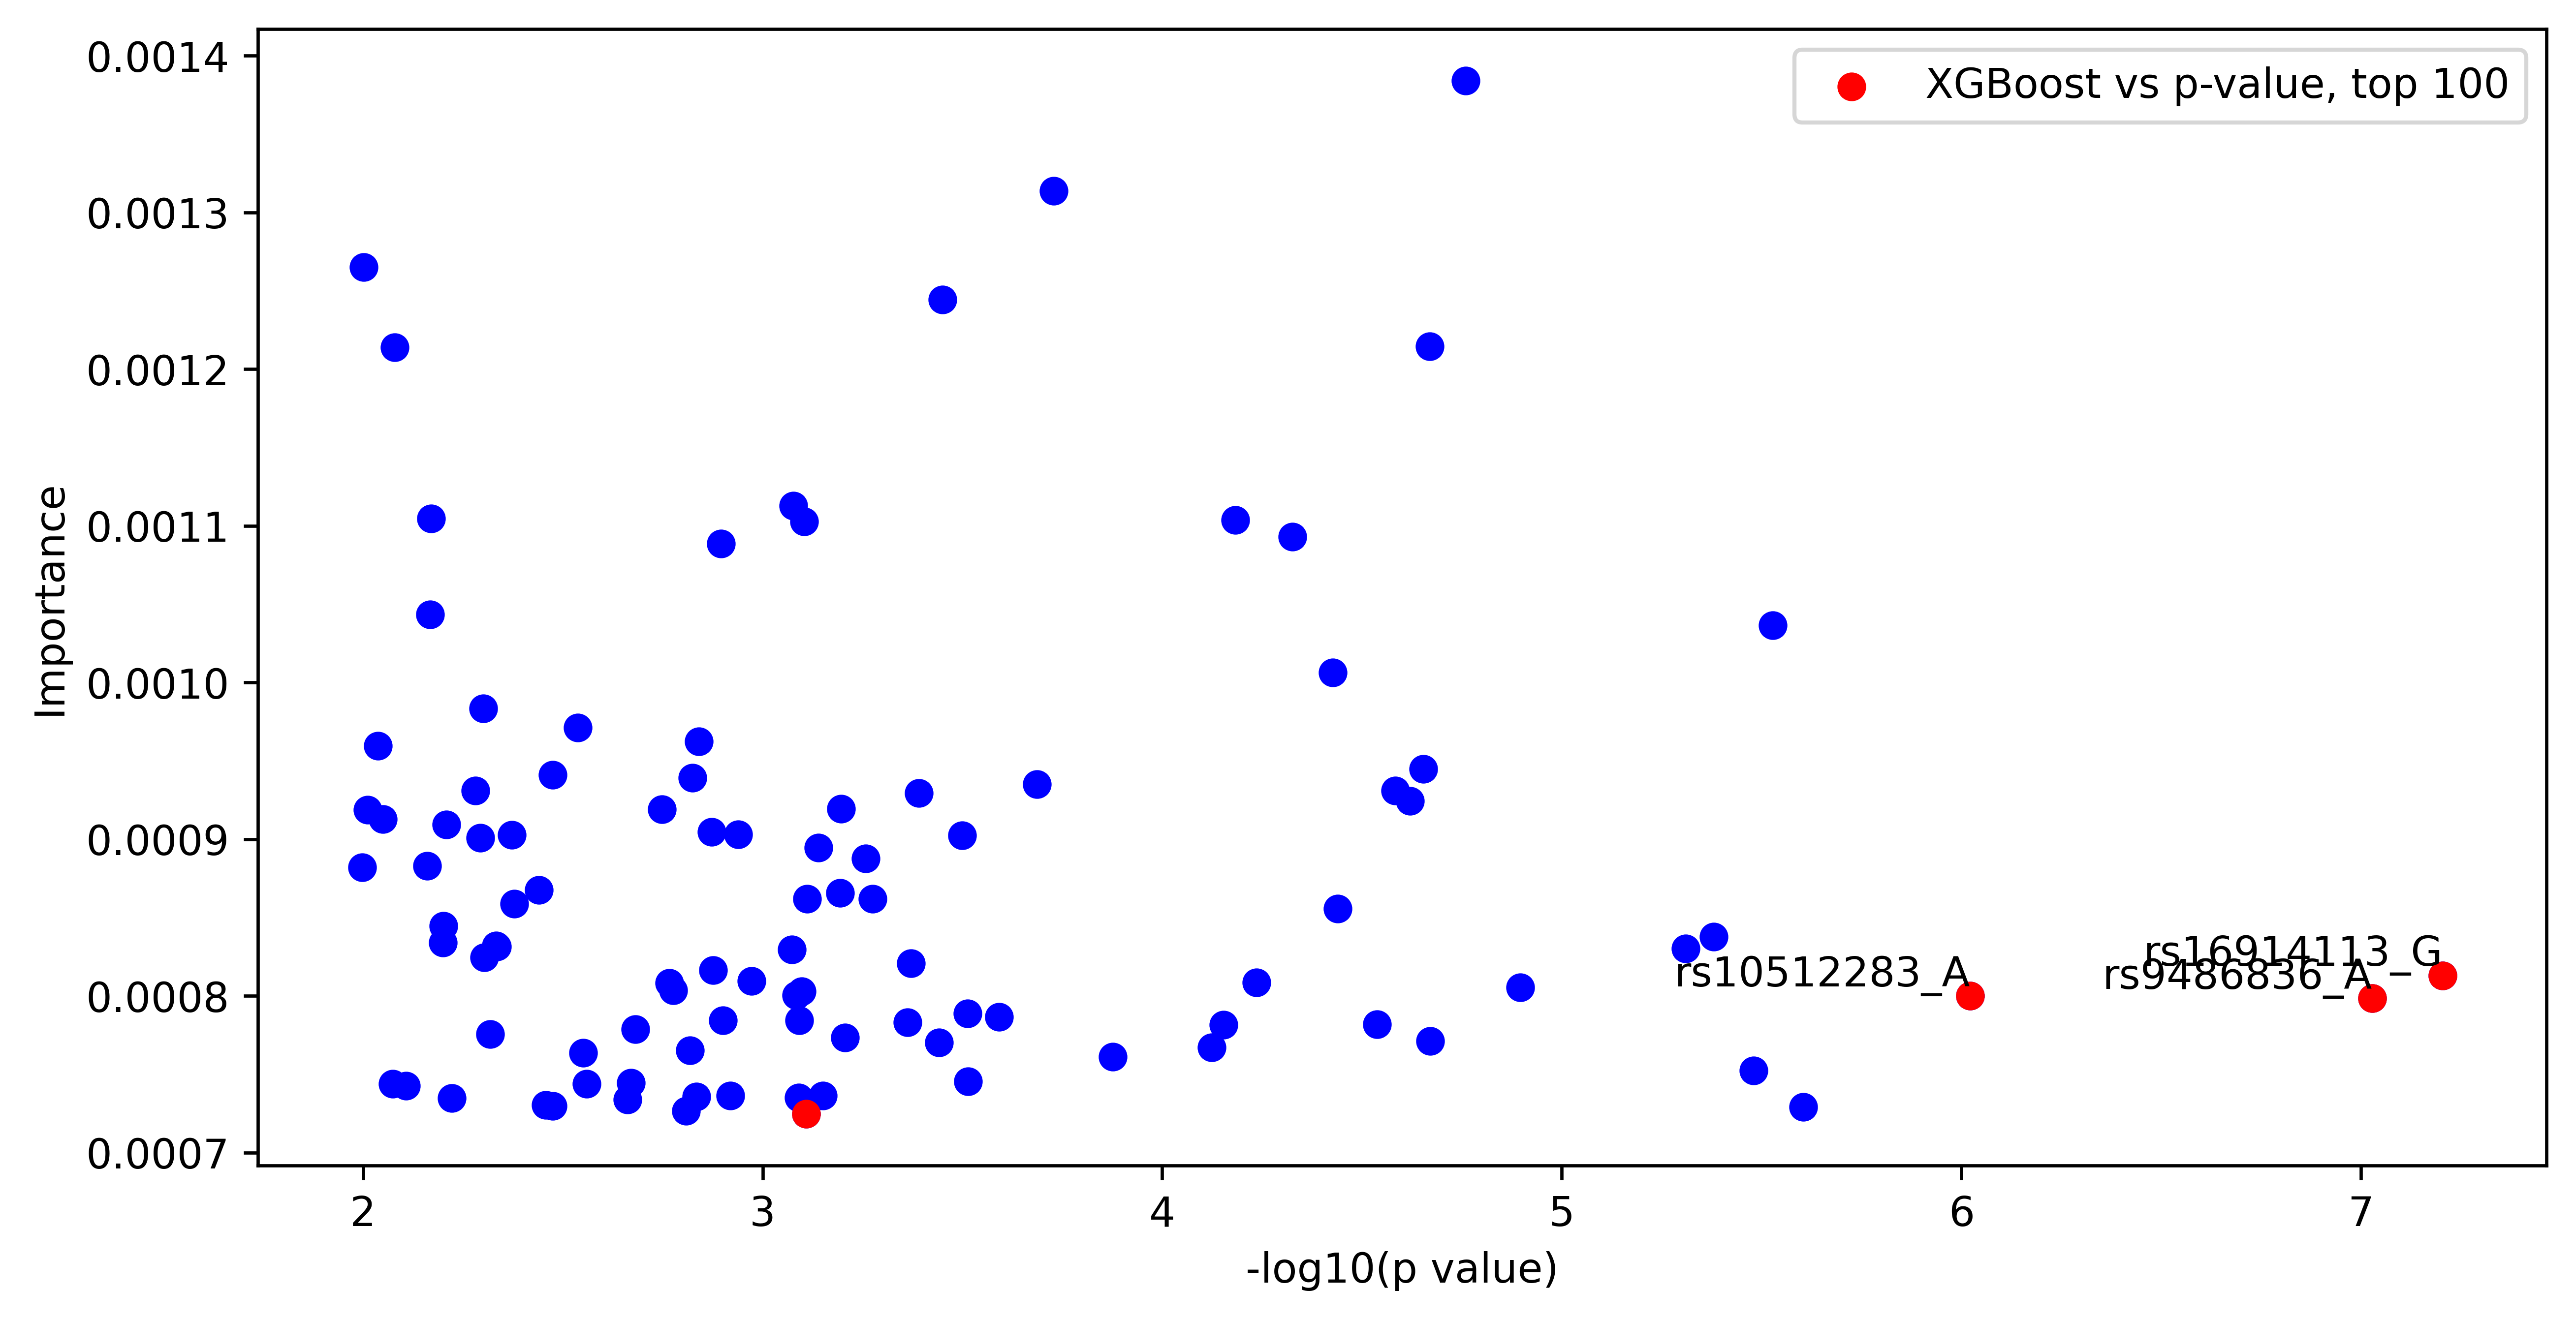

In [77]:
import matplotlib.pyplot as plt
# Plot the figure
plt.figure(figsize=(10, 5), dpi=600)
plt.scatter(top_features_df["-log10(p value)"], top_features_df["Importance"], color="blue")
# Highlight features in top_100_selected as red
for index, row in top_features_df.iterrows():
    feature = row["Feature"]
    if feature in top_100_selected["SNP"].values:
        plt.scatter(row["-log10(p value)"], row["Importance"], color="red")
        plt.annotate(feature, xy=(row["-log10(p value)"], row["Importance"]) ,ha='right', va='bottom')
        
plt.scatter(row["-log10(p value)"], row["Importance"], color="red", label='XGBoost vs p-value, top 100')

plt.xlabel("-log10(p value)")
plt.ylabel("Importance")
plt.legend()
plt.show()


In [78]:
from catboost import CatBoostClassifier, Pool, metrics, cv

In [80]:
# Load the data
X = df.values
y = target

cat_feature_indices = list(range(X.shape[1]))
len(cat_feature_indices)

30000

In [81]:
from catboost import Pool

ros = RandomOverSampler(random_state=42)

X_res, y_res = ros.fit_resample(X, y)

# Creating a Pool for training data
train_pool = Pool(X_res, y_res, cat_features=cat_feature_indices)


In [85]:
params={'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 #'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 168,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 #'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Ordered',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 #'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 #'pinned_memory_bytes': '104857600',
 #'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'GpuRam',
 #'fold_size_loss_normalization': False,
 'max_ctr_complexity': 4,
 'model_size_reg': 0.5,
 'simple_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=MinEntropy:Prior=0/1'],
 #'pool_metainfo_options': {'tags': {}},
 #'use_best_model': True,
 #'meta_l2_frequency': 0,
 'od_wait': 15,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 4,
 'ctr_target_border_count': 1,
 'has_time': False,
 'fold_len_multiplier': 2,
 'border_count': 128,
 #'min_fold_size': 100,
 'data_partition': 'FeatureParallel',
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 #'custom_metric': ['Accuracy', 'Recall', 'F1'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'min_data_in_leaf': 1,
 #'add_ridge_penalty_to_loss_function': False,
 'loss_function': 'Logloss',
 'learning_rate': 0.05999999865889549,
 #'meta_l2_exponent': 1,
 'score_function': 'Cosine',
 'task_type': 'GPU',
 'leaf_estimation_iterations': 10,
 'bootstrap_type': 'Bayesian',
 #'permutation_count': 4,
 'max_leaves': 16
 }

In [86]:
model1 = CatBoostClassifier(**params)

In [87]:
model1.fit(
    train_pool,
    logging_level='Verbose',
    plot=False
)

0:	learn: 0.6904383	total: 12.5s	remaining: 34m 43s
1:	learn: 0.6869507	total: 25.2s	remaining: 34m 49s
2:	learn: 0.6835839	total: 38.3s	remaining: 35m 8s
3:	learn: 0.6804394	total: 51.8s	remaining: 35m 23s
4:	learn: 0.6770406	total: 1m 4s	remaining: 35m 17s
5:	learn: 0.6744515	total: 1m 17s	remaining: 34m 59s
6:	learn: 0.6718819	total: 1m 30s	remaining: 34m 41s
7:	learn: 0.6692732	total: 1m 43s	remaining: 34m 30s
8:	learn: 0.6656536	total: 1m 56s	remaining: 34m 15s
9:	learn: 0.6625825	total: 2m 9s	remaining: 34m 2s
10:	learn: 0.6589884	total: 2m 22s	remaining: 33m 48s
11:	learn: 0.6559496	total: 2m 34s	remaining: 33m 32s
12:	learn: 0.6523762	total: 2m 47s	remaining: 33m 18s
13:	learn: 0.6486409	total: 3m	remaining: 33m 2s
14:	learn: 0.6471182	total: 3m 12s	remaining: 32m 46s
15:	learn: 0.6442255	total: 3m 25s	remaining: 32m 32s
16:	learn: 0.6418887	total: 3m 38s	remaining: 32m 17s
17:	learn: 0.6394140	total: 3m 50s	remaining: 32m 3s
18:	learn: 0.6370370	total: 4m 3s	remaining: 31m 51s

In [112]:
feature_importance = pd.DataFrame({'Importance': model1.get_feature_importance(train_pool), 
              'Feature': df.columns}).sort_values(by=['Importance'], 
                                                       ascending=False)

In [113]:
feature_importance

,Importance,Feature
7,1.760617,rs2819493_A
17,1.374076,rs12592594_G
368,1.059922,rs13359853_A
8,1.038783,rs4669685_A
2434,0.964976,rs12462821_A
...,...,...
10244,0.000000,rs910688_A
10243,0.000000,rs889092_G
10242,0.000000,rs4720309_A
10241,0.000000,rs710141_T


In [114]:
feature_importance.to_csv('CAT_OH_WEIGHT.csv', index=False)

In [91]:
top_features_df = feature_importance.head(100).copy()

In [92]:
# Create a new column for p-values in the top_features_df
top_features_df["p-value"] = None

# Iterate over the rows in top_features_df
for i, row in top_features_df.iterrows():
    feature = row["Feature"]
    # Check if the feature is present in the selected_snps_df
    if feature in selected_snps_df["SNP"].values:
        # Find the corresponding row in selected_snps_df
        matched_row = selected_snps_df[selected_snps_df["SNP"] == feature]
        # Get the p-value from the matched row and assign it to the "p-value" column in top_features_df
        top_features_df.at[i, "p-value"] = matched_row["p-value"].values[0]

# Filter the top 100 features from selected_snps_df
top_100_selected = selected_snps_df.head(100)
# Convert p-values to -log10(p value)
top_features_df["-log10(p value)"] = -np.log10(top_features_df["p-value"].astype(float))
top_features_df

,Importance,Feature,p-value,-log10(p value)
7,1.760617,rs2819493_A,0.0,9.040658
17,1.374076,rs12592594_G,0.0,7.566232
368,1.059922,rs13359853_A,0.000012,4.919060
8,1.038783,rs4669685_A,0.0,8.892683
2434,0.964976,rs12462821_A,0.000246,3.609857
...,...,...,...,...
20694,0.258290,rs12448045_T,0.00603,2.219696
2090,0.257194,rs2238669_A,0.000197,3.705773
2204,0.253738,rs4262688_G,0.000212,3.674165
3715,0.246813,rs2017073_G,0.000454,3.343118


In [93]:
top_features_df.to_csv('CAT_OH_WEIGHT.csv', index=False)

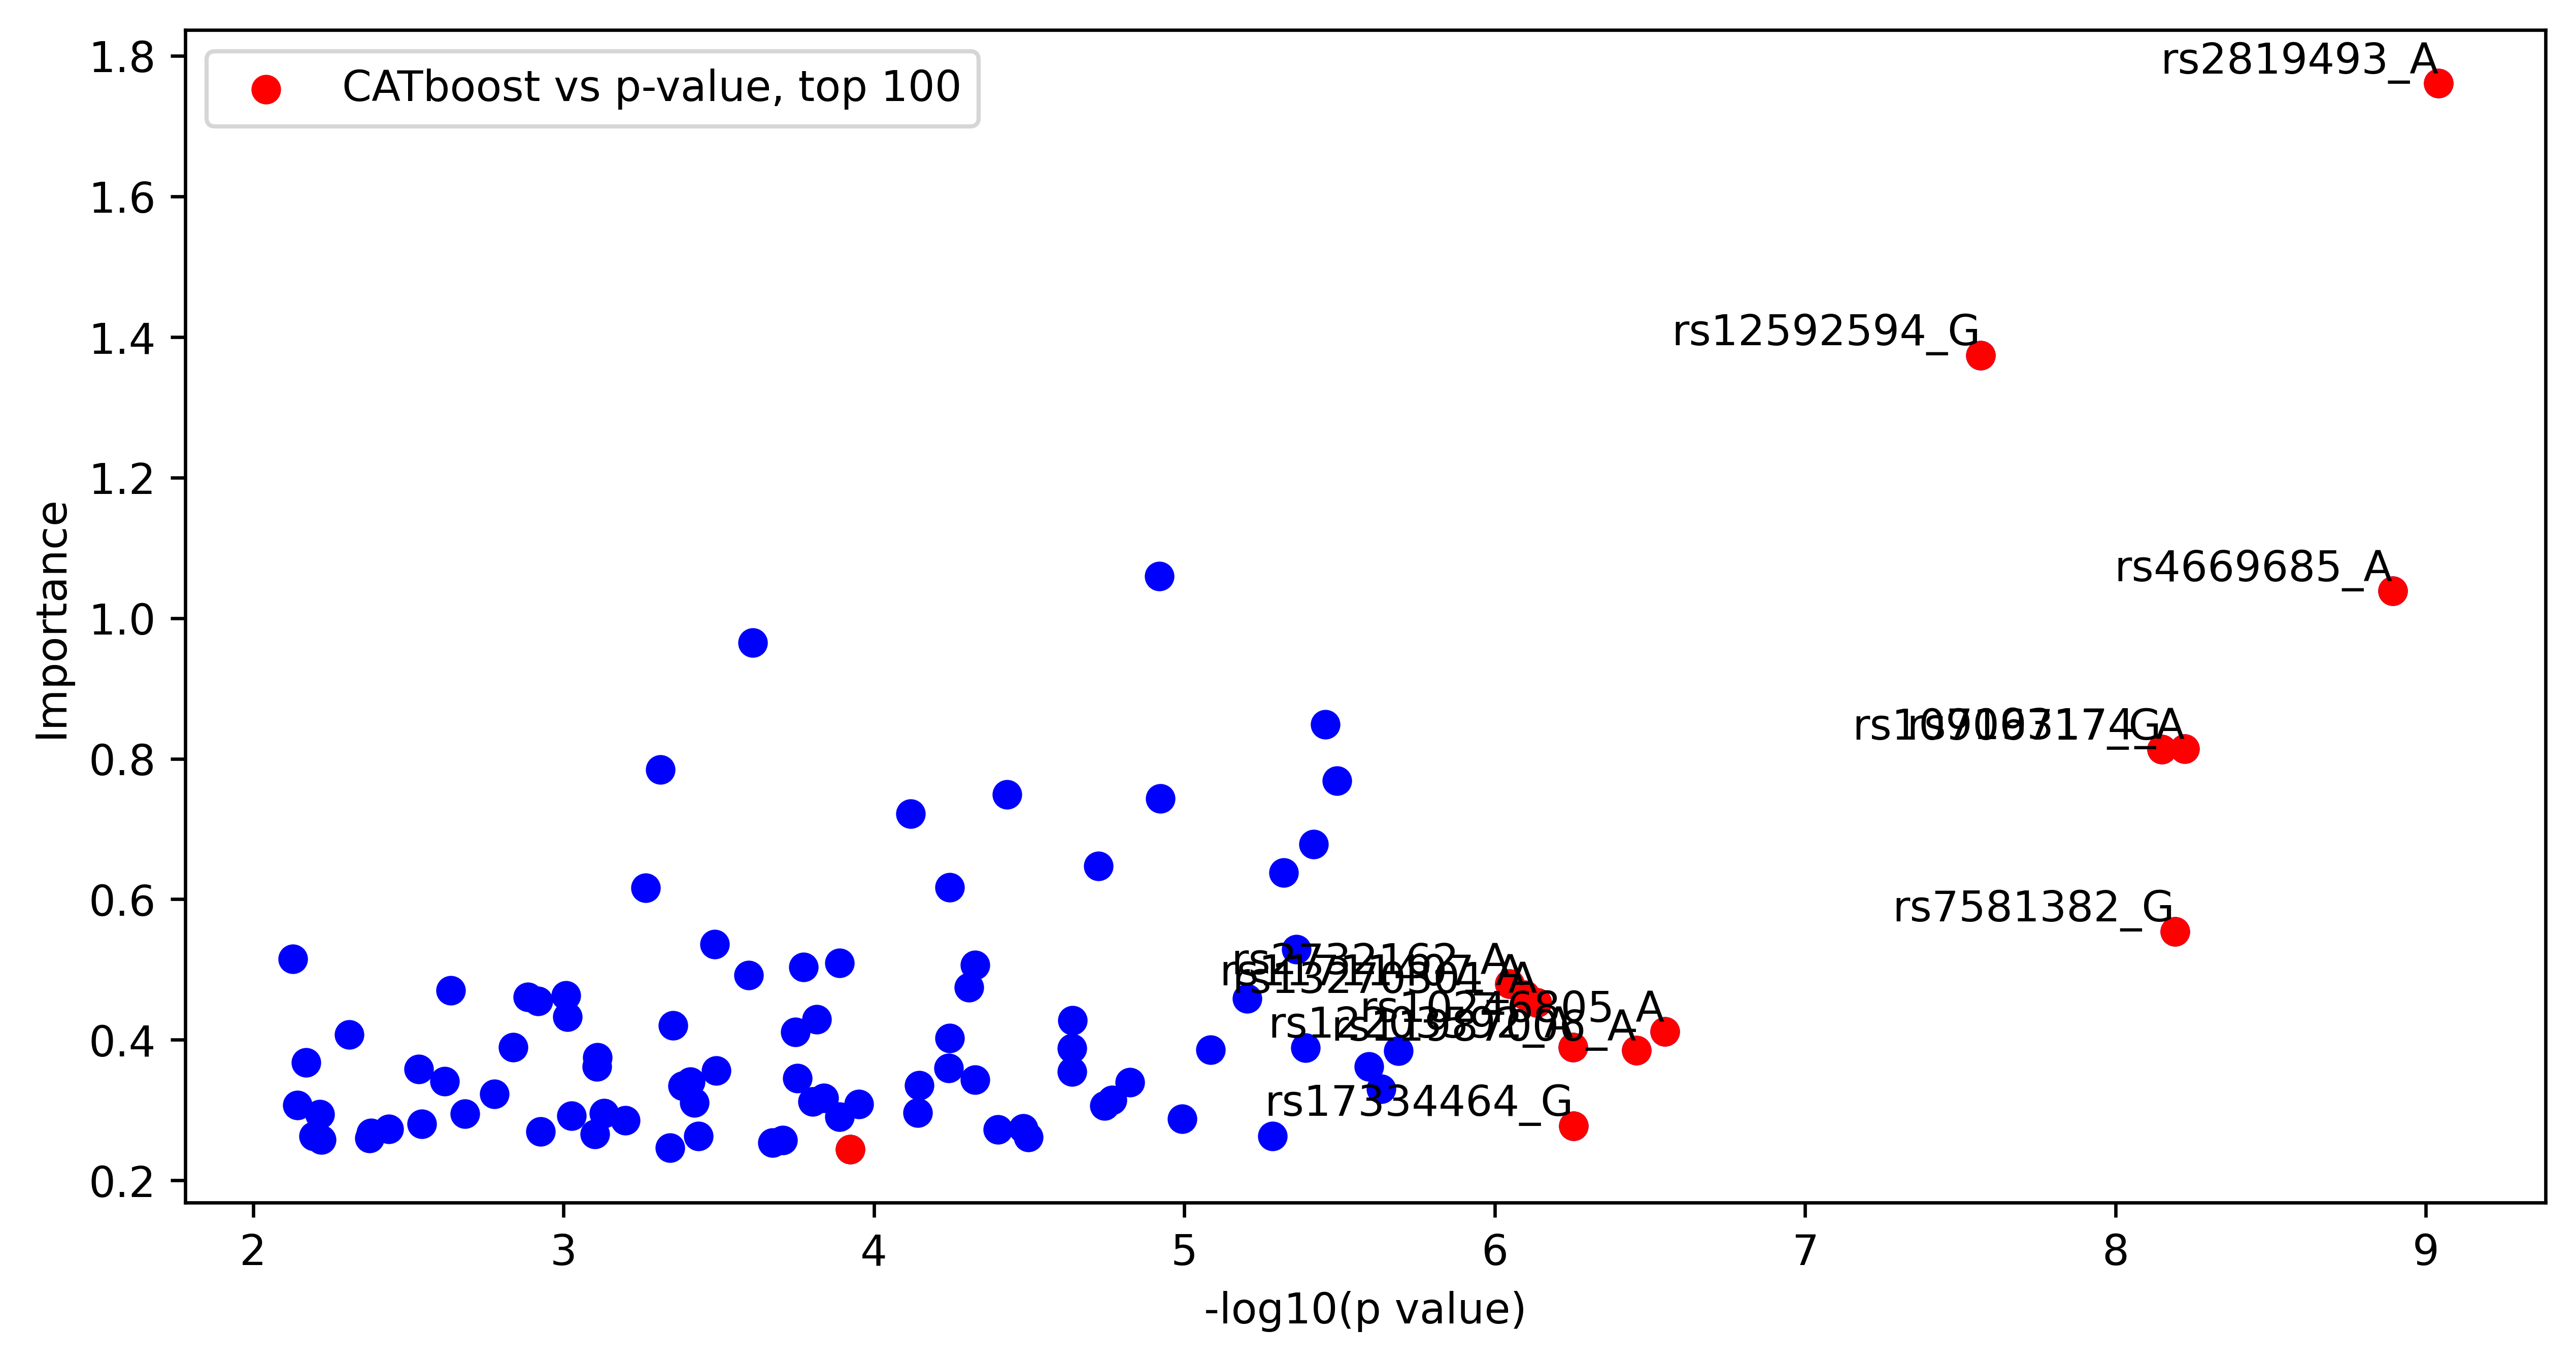

In [95]:
import matplotlib.pyplot as plt
# Plot the figure
plt.figure(figsize=(10, 5), dpi=600)
plt.scatter(top_features_df["-log10(p value)"], top_features_df["Importance"], color="blue")
# Highlight features in top_100_selected as red
for index, row in top_features_df.iterrows():
    feature = row["Feature"]
    if feature in top_100_selected["SNP"].values:
        plt.scatter(row["-log10(p value)"], row["Importance"], color="red")
        plt.annotate(feature, xy=(row["-log10(p value)"], row["Importance"]) ,ha='right', va='bottom')
        
plt.scatter(row["-log10(p value)"], row["Importance"], color="red", label='CATboost vs p-value, top 100')

plt.xlabel("-log10(p value)")
plt.ylabel("Importance")
plt.legend()
plt.show()


In [96]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

In [97]:
# Load the data
X = df.values
y = target

cat_idxs = list(range(df.shape[1]))  # All features are categorical
cat_dims = [df[col].nunique() for col in df.columns] 

ros = RandomOverSampler(random_state=42)

X_res, y_res = ros.fit_resample(X, y)

In [98]:
# define the model
clf= TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       scheduler_params={"step_size":30, 
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       seed=0,
                       cat_idxs=cat_idxs,
                       cat_dims=cat_dims
                      )

# fit the model 
clf.fit(
    X, y,
    #eval_set=[(X_res, y_res), (X_test, y_test)],
    #eval_name=['train', 'test'],
    #eval_metric=['auc','accuracy'],
    max_epochs=11, 
    patience=6,
    batch_size=256, 
    virtual_batch_size=128,
    weights=1,
    drop_last=False
)   

/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")
/opt/conda/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:651: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.80209 |  0:02:06s
epoch 1  | loss: 0.69086 |  0:04:12s
epoch 2  | loss: 0.66448 |  0:06:19s
epoch 3  | loss: 0.61071 |  0:08:24s
epoch 4  | loss: 0.46735 |  0:10:29s
epoch 5  | loss: 0.31373 |  0:12:34s
epoch 6  | loss: 0.18872 |  0:14:38s
epoch 7  | loss: 0.11768 |  0:16:43s
epoch 8  | loss: 0.09537 |  0:18:46s
epoch 9  | loss: 0.07964 |  0:20:50s
epoch 10 | loss: 0.08925 |  0:22:54s


In [105]:
# Analyze feature importance
feature_importance = clf.feature_importances_

# Create a dataframe for feature importance
feature_importance_df = pd.DataFrame({'Feature': df.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
11361,rs9823025_G,0.502952
14858,rs2296742_A,0.214389
13809,rs10830488_G,0.106535
16922,rs4278209_A,0.033285
24619,rs17164627_A,0.014297
...,...,...
10032,rs783847_A,0.000000
10031,rs7155641_G,0.000000
10030,rs2022243_G,0.000000
10029,rs370025_A,0.000000


In [108]:
feature_importance_df.to_csv('TAB_WEIGHT.csv', index=False)

In [100]:
top_features_df = feature_importance_df.head(100).copy()

In [101]:
# Create a new column for p-values in the top_features_df
top_features_df["p-value"] = None

# Iterate over the rows in top_features_df
for i, row in top_features_df.iterrows():
    feature = row["Feature"]
    # Check if the feature is present in the selected_snps_df
    if feature in selected_snps_df["SNP"].values:
        # Find the corresponding row in selected_snps_df
        matched_row = selected_snps_df[selected_snps_df["SNP"] == feature]
        # Get the p-value from the matched row and assign it to the "p-value" column in top_features_df
        top_features_df.at[i, "p-value"] = matched_row["p-value"].values[0]

# Filter the top 100 features from selected_snps_df
top_100_selected = selected_snps_df.head(100)
# Convert p-values to -log10(p value)
top_features_df["-log10(p value)"] = -np.log10(top_features_df["p-value"].astype(float))
top_features_df

,Feature,Importance,p-value,-log10(p value)
11361,rs9823025_G,0.502952,0.002502,2.601750
14858,rs2296742_A,0.214389,0.003707,2.430957
13809,rs10830488_G,0.106535,0.003338,2.476495
16922,rs4278209_A,0.033285,0.004496,2.347195
24619,rs17164627_A,0.014297,0.00772,2.112406
...,...,...,...,...
483,rs515883_A,0.000048,0.00002,4.708954
3343,rs6005861_G,0.000047,0.000392,3.407258
2850,rs11169335_G,0.000044,0.000309,3.510244
28414,rs6453644_A,0.000044,0.009457,2.024245


In [102]:
top_features_df.to_csv('TAB_WEIGHT.csv', index=False)

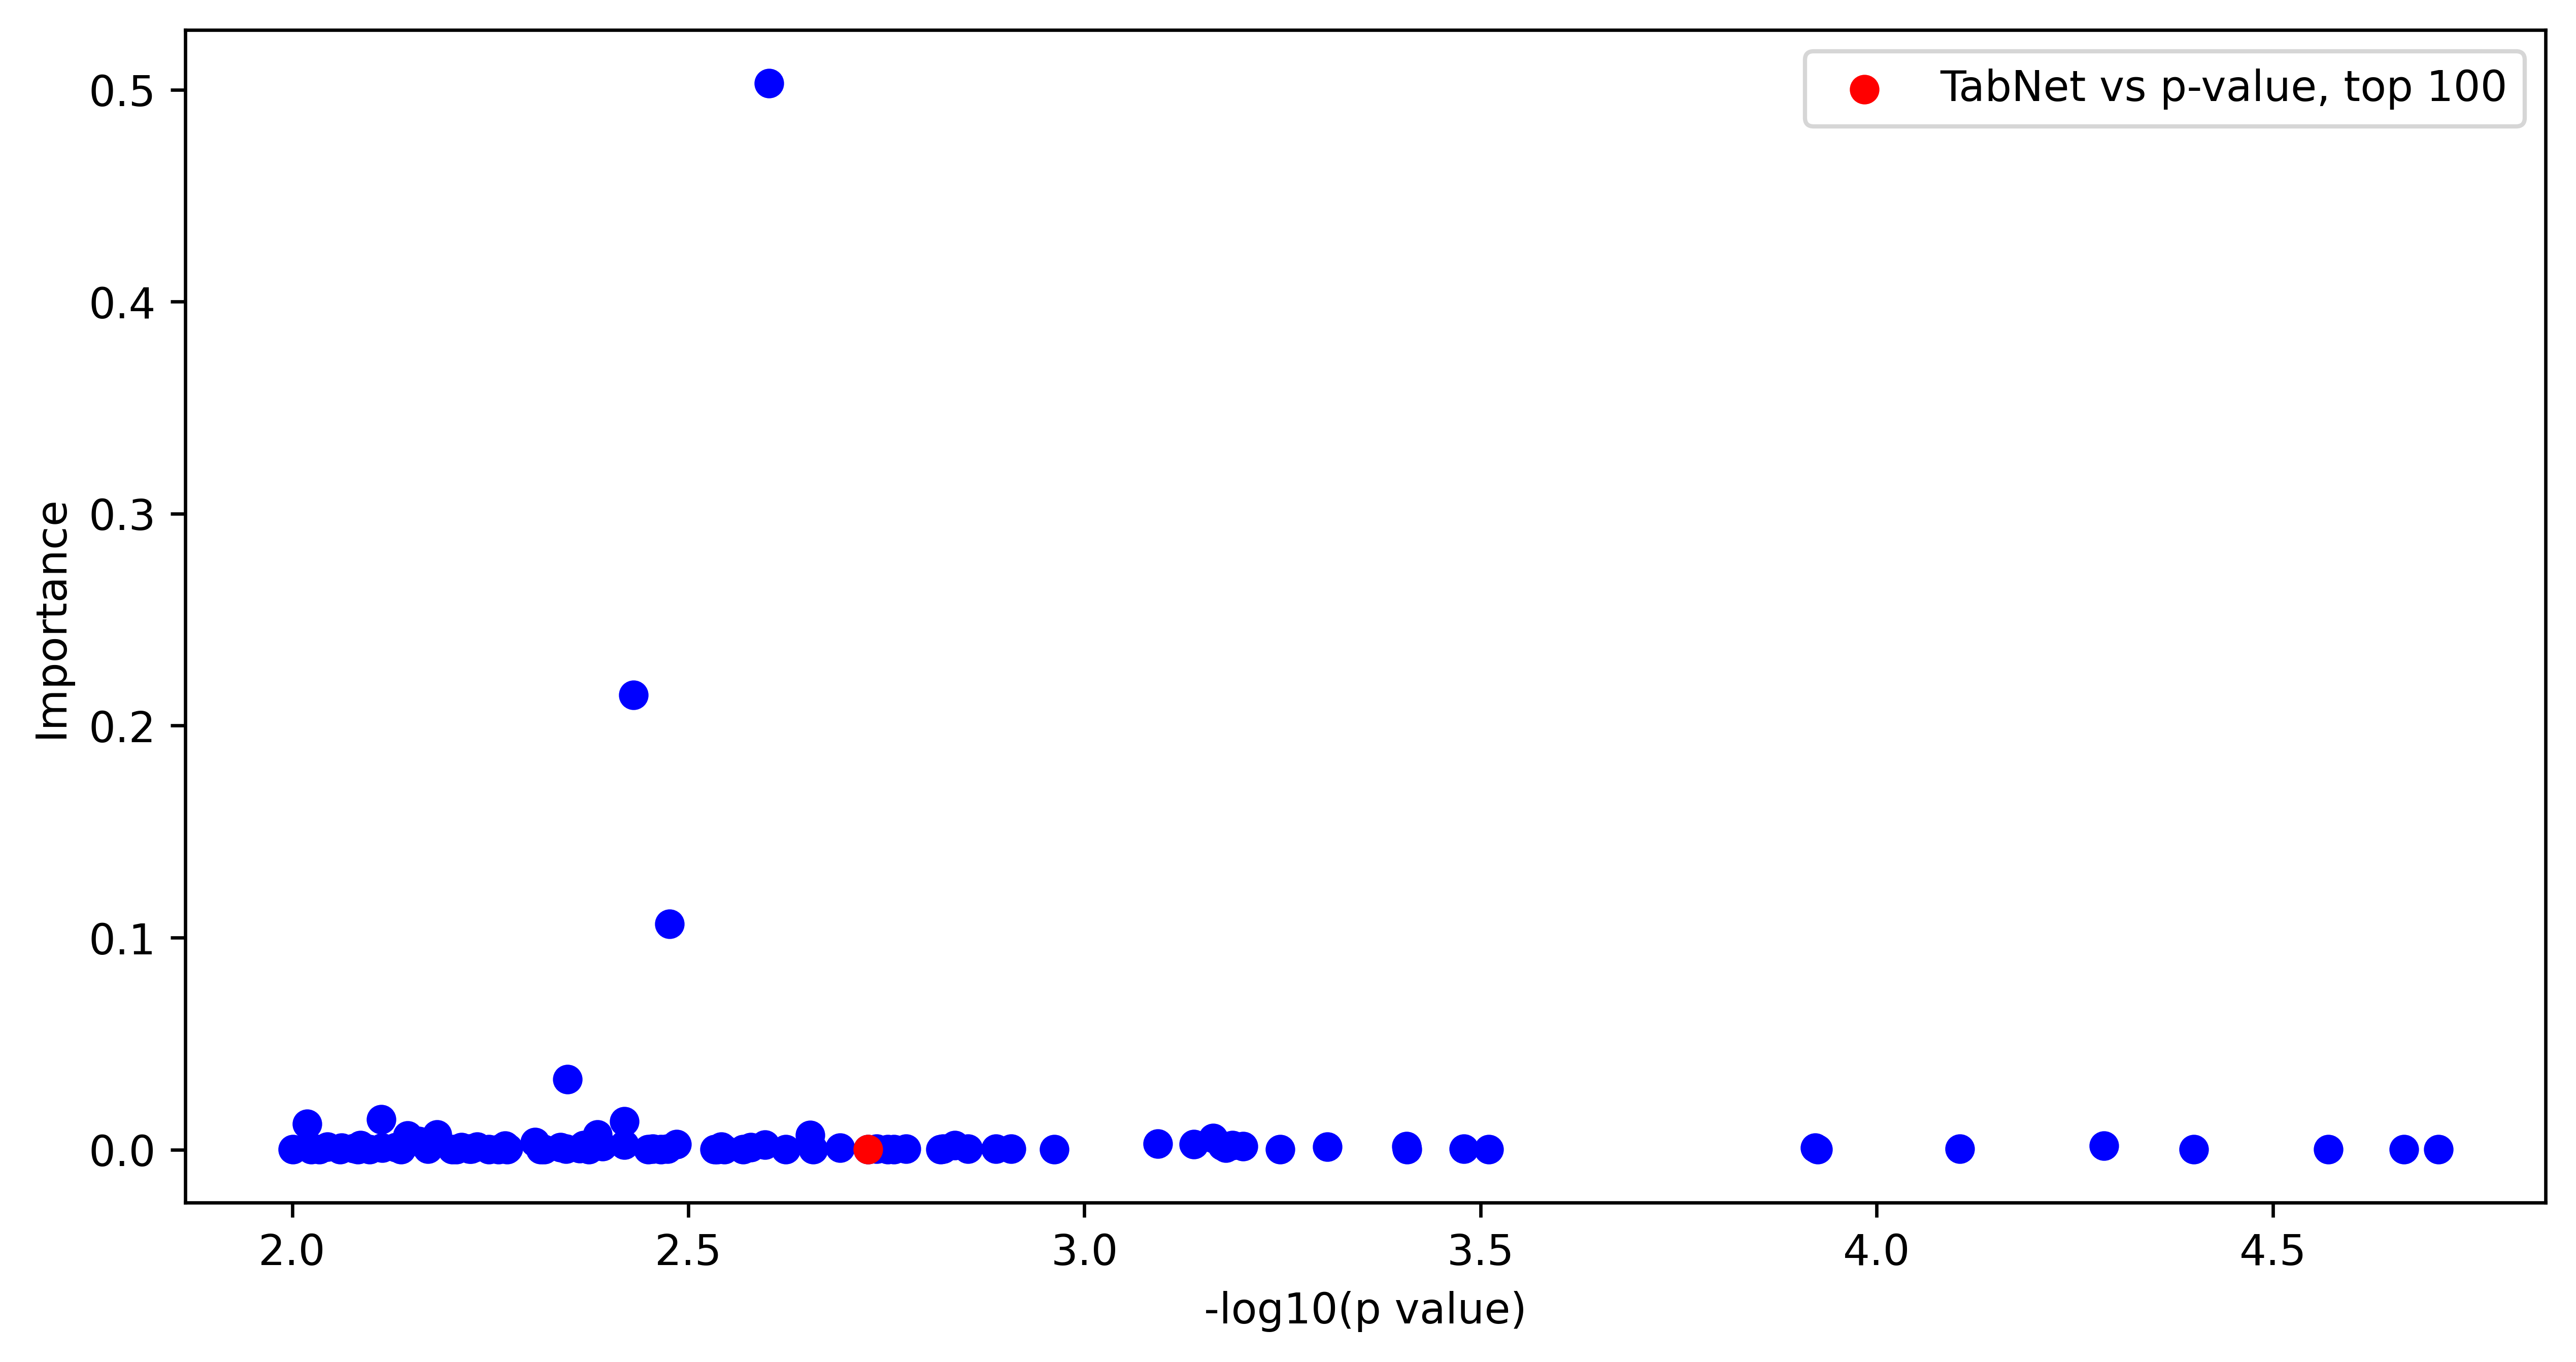

In [104]:
import matplotlib.pyplot as plt
# Plot the figure
plt.figure(figsize=(10, 5), dpi=600)
plt.scatter(top_features_df["-log10(p value)"], top_features_df["Importance"], color="blue")
# Highlight features in top_100_selected as red
for index, row in top_features_df.iterrows():
    feature = row["Feature"]
    if feature in top_100_selected["SNP"].values:
        plt.scatter(row["-log10(p value)"], row["Importance"], color="red")
        plt.annotate(feature, xy=(row["-log10(p value)"], row["Importance"]) ,ha='right', va='bottom')
        
plt.scatter(row["-log10(p value)"], row["Importance"], color="red", label='TabNet vs p-value, top 100')

plt.xlabel("-log10(p value)")
plt.ylabel("Importance")
plt.legend()
plt.show()
